In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from matplotlib import colors
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Data processing

In [33]:
fname = "../data/WEBER.DAT"

columns = ["Electric", "Heating", "Cooling", "light_hours", "light", "roof", "OA", "DBST"]
raw_df = pd.read_csv(fname, delimiter="\s+", skiprows=25, header=None, names=columns)

In [34]:
df = deepcopy(raw_df)

map_light_hours = {95: 1, 100: 2}
map_light = {2: 1, 3: 2}
map_roof = {0.044: 1, 0.080: 2}
map_OA = {40: 1, 50: 2}
map_DBST = {-150: 1, 75: 2}

df["light_hours"] = df["light_hours"].map(map_light_hours)
df["light"] = df["light"].map(map_light)
df["roof"] = df["roof"].map(map_roof)
df["OA"] = df["OA"].map(map_OA)
df["DBST"] = df["DBST"].map(map_DBST)

In [90]:
Z = df.to_numpy()
X = Z[:, 3:8] #- 1
y = Z[:, 0] / 10000 # (np.max(y) - np.min(y))
y = y.reshape((-1, 1))

num_data = X.shape[0]

# Analysis
## Rashomon

In [39]:
from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import RAggregate_profile, RAggregate
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache


%load_ext autoreload
%autoreload 2

In [92]:
def print_pools(R_set, rashomon_profiles, idx, profiles, policies_mask, all_policies=None,
               policy_means=None):
    r_set = R_set[idx]
    
    pi_policies_profiles_r = {}
    for k, profile in enumerate(profiles):
        if rashomon_profiles[k].sigma[r_set[k]] is None and rashomon_profiles[k].Q[r_set[k]] == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_mask[k]))}
            pass
        else:
            _, pi_policies_r_k = extract_pools.extract_pools(
                policies_profiles_masked[k],
                rashomon_profiles[k].sigma[r_set[k]]
            )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    if policy_means is not None:
        pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    else:
        pool_means_r = None
    
    for k, v in pi_pools_r.items():
        if all_policies is not None:
            print(k, ":", [all_policies[x] for x in v])
        else:
            print(k, ":", v)
        if pool_means_r is not None:
            print(pool_means_r[k])

Setup the policy and profile list

In [93]:
M = 5
# R = np.array([3, 4, 3])
R = 3

num_profiles = 2**M
profiles, profile_map = tva.enumerate_profiles(M)

all_policies = tva.enumerate_policies(M, R)
num_policies = len(all_policies)

In [94]:
policies_profiles = {}
policies_profiles_masked = {}
policies_ids_profiles = {}
for k, profile in enumerate(profiles):

    policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
    unzipped_temp = list(zip(*policies_temp))
    policies_ids_k = list(unzipped_temp[0])
    policies_k = list(unzipped_temp[1])
    policies_profiles[k] = deepcopy(policies_k)
    policies_ids_profiles[k] = policies_ids_k

    profile_mask = list(map(bool, profile))

    # Mask the empty arms
    for idx, pol in enumerate(policies_k):
        policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
    policies_profiles_masked[k] = policies_k

Setup the data and compute policy-wise means

In [95]:
D = np.zeros(shape=y.shape, dtype=np.int64)
profiles_in_data = []
for i in range(num_data):
    policy_i = tuple([int(x) for x in X[i, :]])
    policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
    profiles_in_data.append(tva.policy_to_profile(policy_i))
    D[i, 0] = int(policy_idx[0])

policy_means = loss.compute_policy_means(D, y, num_policies)

In [96]:
nodata_idx = np.where(policy_means[:, 1] == 0)[0]
policy_means[nodata_idx, 0] = -np.inf
policy_means[nodata_idx, 1] = 1
mu_policies = policy_means[:, 0] / policy_means[:, 1]

true_best_eff = np.max(mu_policies)
print(true_best_eff)
np.where(mu_policies == true_best_eff)

3.378528906


(array([238, 239, 241, 242]),)

Enumerate the Rashomon set

In [118]:
reg = 1e-3
q =  1e-2
R_set, rashomon_profiles = RAggregate(M, R, np.inf, D, y, q, reg=reg)
# R_set, rashomon_profiles = RAggregate(M, R, 10, D, y, q, reg=reg)

print(len(R_set))

8


In [119]:
best_profile_counter = np.zeros(shape=(num_profiles,))

all_losses = []

best_loss = np.inf
best_policy_o = None

for r_set in R_set:
    pi_policies_profiles_r = {}

    for k, profile in enumerate(profiles):
        if rashomon_profiles[k].sigma[r_set[k]] is None and rashomon_profiles[k].Q[r_set[k]] == 0:
            pi_policies_r_k = {i: None for i in range(len(policies_profiles_masked[k]))}
            pass
        else:
            _, pi_policies_r_k = extract_pools.extract_pools(
                policies_profiles_masked[k],
                rashomon_profiles[k].sigma[r_set[k]]
            )
        pi_policies_profiles_r[k] = pi_policies_r_k
    
    pi_pools_r, pi_policies_r = extract_pools.aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
    pool_means_r = loss.compute_pool_means(policy_means, pi_pools_r)
    
    y_pred = metrics.make_predictions(D, pi_policies_r, pool_means_r)

    this_loss = mean_squared_error(y, y_pred) + reg * len(pi_pools_r)
    all_losses.append((this_loss, mean_squared_error(y, y_pred), len(pi_pools_r), np.nanmax(pool_means_r)))
    
    # best_pools = np.argwhere(pool_means_r == np.max(pool_means_r))[0]
    best_pools = np.argwhere(pool_means_r == np.nanmax(pool_means_r))[0]
    # print(np.max(pool_means_r))

    for best_pool in best_pools:
        best_policy_id = pi_pools_r[best_pool][0]
        best_policy = all_policies[best_policy_id]
        best_profile = tva.policy_to_profile(best_policy)
        profile_id = profile_map[best_profile]

        best_profile_counter[profile_id] += 1
        
        if this_loss < best_loss:
            best_loss = this_loss
            best_policy_o = best_policy
            print(best_loss, best_policy, len(pi_pools_r))
            # for k, v in pi_pools_r.items():
            #     print(k, ":", [all_policies[x] for x in v], v)
            #     print(pool_means_r[k])
            # print("---")

best_profile_freq = best_profile_counter / np.sum(best_profile_counter)

print(f"Best model loss {best_loss} and best policy {best_policy_o}")

0.005318597665447322 (2, 2, 1, 1, 1) 4
Best model loss 0.005318597665447322 and best policy (2, 2, 1, 1, 1)


In [120]:
for loss_i, mse_i, size_i, best_eff_i in all_losses:
    # if size_i > 10:
    #     continue
    sqrd_err_best_pol_i = (best_eff_i - true_best_eff)**2
    log_post_ratio = np.exp(-loss_i) / np.exp(-best_loss)
    # log_post_ratio = np.log(log_post_ratio)
    # log_post_ratio = loss_i / best_loss
    print(f"{size_i}: {mse_i:.5e} ({loss_i:.5e}) & {sqrd_err_best_pol_i:.3e} & {log_post_ratio:.6e}")

4: 1.31860e-03 (5.31860e-03) & 1.319e-03 & 1.000000e+00
2: 4.83963e-03 (6.83963e-03) & 1.126e-02 & 9.984801e-01
4: 3.52103e-03 (7.52103e-03) & 4.875e-03 & 9.978000e-01
8: 0.00000e+00 (8.00000e-03) & 0.000e+00 & 9.973222e-01
4: 4.83963e-03 (8.83963e-03) & 1.126e-02 & 9.964852e-01
4: 4.83963e-03 (8.83963e-03) & 1.126e-02 & 9.964852e-01
8: 1.31860e-03 (9.31860e-03) & 1.319e-03 & 9.960080e-01
8: 1.31860e-03 (9.31860e-03) & 1.319e-03 & 9.960080e-01


In [148]:
print_pools(R_set, rashomon_profiles, 3, profiles, policies_profiles_masked, all_policies,
           policy_means)

0 : [(1, 1, 1, 1, 1), (1, 1, 1, 1, 2), (1, 1, 1, 2, 1), (1, 1, 1, 2, 2)]
2.561231055
1 : [(1, 1, 2, 1, 1), (1, 1, 2, 1, 2), (1, 1, 2, 2, 1), (1, 1, 2, 2, 2)]
2.633856055
2 : [(1, 2, 1, 1, 1), (1, 2, 1, 1, 2), (1, 2, 1, 2, 1), (1, 2, 1, 2, 2)]
3.1662570309999998
3 : [(1, 2, 2, 1, 1), (1, 2, 2, 1, 2), (1, 2, 2, 2, 1), (1, 2, 2, 2, 2)]
3.238883008
4 : [(2, 1, 1, 1, 1), (2, 1, 1, 1, 2), (2, 1, 1, 2, 1), (2, 1, 1, 2, 2)]
2.654328906
5 : [(2, 1, 2, 1, 1), (2, 1, 2, 1, 2), (2, 1, 2, 2, 1), (2, 1, 2, 2, 2)]
2.72695293
6 : [(2, 2, 1, 1, 1), (2, 2, 1, 1, 2), (2, 2, 1, 2, 1), (2, 2, 1, 2, 2)]
3.305903906
7 : [(2, 2, 2, 1, 1), (2, 2, 2, 1, 2), (2, 2, 2, 2, 1), (2, 2, 2, 2, 2)]
3.378528906


In [149]:
R_set[3]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3]

In [150]:
rashomon_profiles[31].sigma[3]

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.]])

### Analyzing the Rashomon set

In [121]:
model_sizes = [x[2] for x in all_losses]
print(np.min(model_sizes), np.max(model_sizes))

2 8


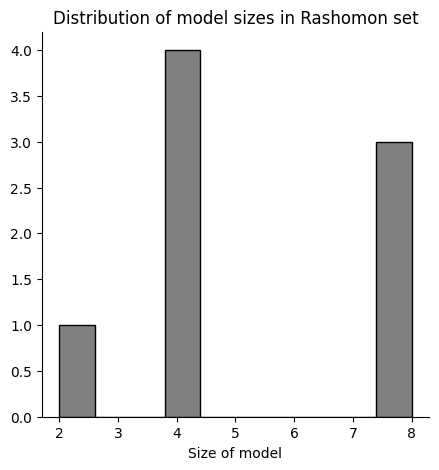

In [125]:
fig, ax = plt.subplots(figsize=(5,5))

ax.spines[['right', 'top']].set_visible(False)

ax.hist(model_sizes,
        color="grey", edgecolor="black")

ax.set_xlabel("Size of model")
ax.set_ylabel("")
ax.set_title("Distribution of model sizes in Rashomon set")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.savefig("../Figures/weber/rset_size_dist.png", dpi=300, bbox_inches="tight")
plt.show()

In [128]:
losses_only = np.array([np.exp(-x[0]) for x in all_losses])
losses_only = losses_only - np.min(losses_only)
losses_only = losses_only / np.max(losses_only) #* 70

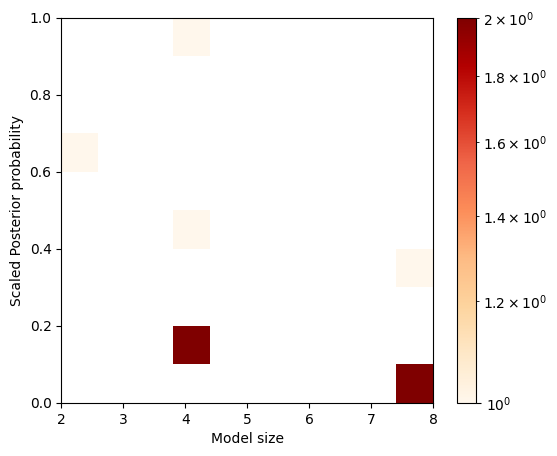

In [131]:
fig, ax = plt.subplots(figsize=(6,5))

h = ax.hist2d(model_sizes, losses_only, norm=colors.LogNorm(),
             cmap="OrRd")
fig.colorbar(h[3], norm=colors.NoNorm, ax=ax)

ax.set_xlabel("Model size")
ax.set_ylabel("Scaled Posterior probability")


# plt.savefig("../Figures/weber/rset_2d_hist.png", dpi=300, bbox_inches="tight")
plt.show()

In [141]:
splits_1 = np.zeros(rashomon_profiles[31].sigma[0].shape)
# splits_2 = np.zeros(rashomon_profiles[15].sigma[0].shape)

for r_set in R_set:
    idx_1 = r_set[31]
    # idx_2 = r_set[15]

    splits_1 += np.abs(rashomon_profiles[31].sigma[idx_1] - 1)
    # splits_2 += np.abs(rashomon_profiles[15].sigma[idx_2] - 1)

splits_1 = splits_1 / len(R_set) * 100
# splits_2 = splits_2 / len(R_set) * 100

In [142]:
splits_1

array([[ 50.],
       [100.],
       [ 25.],
       [ 25.],
       [ 25.]])

## Lasso

In [45]:
from sklearn import linear_model

In [97]:
G = tva.alpha_matrix(all_policies)
D_matrix = tva.get_dummy_matrix(D, G, num_policies)

In [122]:
lasso = linear_model.Lasso(5e-2, fit_intercept=False)
lasso.fit(D_matrix, y)
alpha_est = lasso.coef_
y_tva = lasso.predict(D_matrix)

In [123]:
sqrd_err = mean_squared_error(y, y_tva)
print(sqrd_err)

lasso_loss = sqrd_err + 1e-1 * np.linalg.norm(alpha_est, ord=1)
print(lasso_loss)

0.00895565157471326
0.3270119543405817


In [49]:
best_pol_effect_tva = np.max(y_tva)
sqrd_err_best_pol_tva = (true_best_eff - best_pol_effect_tva)**2
print(f"{sqrd_err_best_pol_tva:.3e}")

best_pol_idx_tva = np.unique(D[np.where(y_tva == best_pol_effect_tva)])
for idx in best_pol_idx_tva:
    print(idx, all_policies[idx])

6.400e-07
238 (2, 2, 2, 1, 1)
239 (2, 2, 2, 1, 2)
241 (2, 2, 2, 2, 1)
242 (2, 2, 2, 2, 2)
